In [1]:
import sys
sys.path.append('../')
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import random
import numpy as np
from utils import *
%matplotlib inline

In [4]:
!ls ../external_data/messidor/

train.csv  train_images  train_messidor.csv


In [8]:
# read all three data labels files
train1 = pd.read_csv('../data/train.csv')
train2 = pd.read_csv('../data/train_old.csv')
train3 = pd.read_csv('../data/train_messidor.csv')

In [9]:
# concatenate into one
train1['path'] = train1['id_code'].apply(lambda x: "../data/train_images/" + x + ".png")
train2['path'] = train2['id_code'].apply(lambda x: "../external_data/train_images/" + x + ".jpeg")
train3['path'] = train3['id_code'].apply(lambda x: "../external_data/messidor/train_images/" + x + ".tif")
train_df = pd.concat([train1, train2, train3], axis=0)

In [10]:
train_df.head()


,id_code,diagnosis,path
0,000c1434d8d7,2,../data/train_images/000c1434d8d7.png
1,001639a390f0,4,../data/train_images/001639a390f0.png
2,0024cdab0c1e,1,../data/train_images/0024cdab0c1e.png
3,002c21358ce6,0,../data/train_images/002c21358ce6.png
4,005b95c28852,0,../data/train_images/005b95c28852.png


In [36]:
def load_rgb(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

def load_ben_color(path, sigmaX=10 ):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

def load_ben_color_cropped(path, IMG_SIZE, sigmaX=10, tol=7):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image, tol=tol)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

def load_ben_gray(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(
       image, 4, cv2.GaussianBlur(image, (0, 0), IMG_SIZE / 10), -4, 128
    )  # Ben Graham's preprocessing method [1]
    ## (IMG_SIZE, IMG_SIZE) -> (IMG_SIZE, IMG_SIZE, 3)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    image = np.repeat(image, 3, axis=-1)
    return image

def crop_image_from_gray(img,tol=7):
#     pdb.set_trace()
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [43]:
names = train_df.id_code.values
save_folder = '../data/train_images/'
IMG_SIZE = 300
mkdir('../data/train_images/bgcc300/')

In [48]:
train_df.shape

(39988, 3)

In [49]:
# this thing is slow at start (the png and tif images) then speeds up after ~5k iterations (the jpegs)
for idx, row in tqdm(train_df.iterrows()):
    name = row.id_code
    path = row.path
    image = load_ben_color_cropped(path, IMG_SIZE, tol=8)
    np.save(os.path.join(save_folder, 'bgcc300', name + '.npy'), image)

39988it [32:22, 11.26it/s]


### Analysis

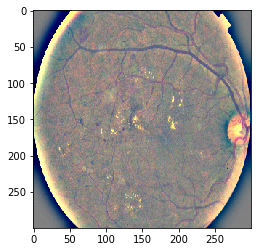

In [47]:
image = np.load('../data/train_images/bgcc300/000c1434d8d7.npy')
plt.imshow(image)

../data/train_images/npy_bengrahm_color/36492_right.npy


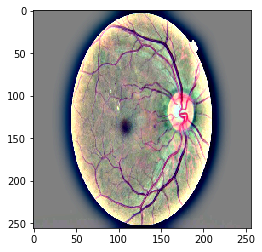

In [79]:
npy_files = glob('../data/train_images/npy_bengrahm_color/*.npy')
npy = np.random.choice(npy_files)
print(npy)
image = np.load(npy)
plt.imshow(image); 

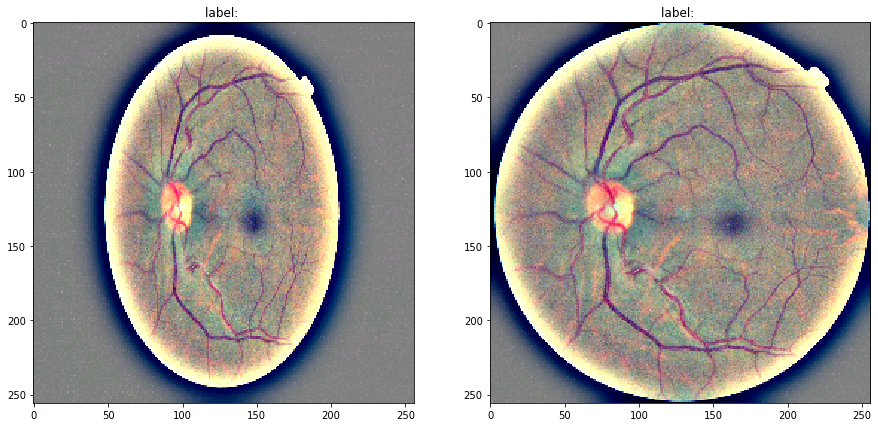

In [224]:
# idx=0
idx+=1
#print(idx)
#fname = names[idx]
fname = "20060523_50153_0100_PP"
image_folder = '../external_data/messidor/train_images/'
img_path = os.path.join(images_folder, fname + ".tif")
image_org = load_ben_color(img_path)
image_cropped = load_ben_color_cropped(img_path, tol=10)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(image_org, cmap="gray")
label = ''
#label = str(train_df.iloc[idx]['diagnosis'])
plt.title('label: ' + label)
plt.subplot(1, 2, 2)
plt.imshow(image_cropped, cmap="gray")
plt.title('label: ' + label) 
plt.show();

In [210]:
image = cv2.imread(img_path)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask = gray_img> 8 


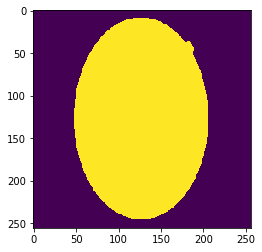

In [211]:
plt.imshow(mask)

In [ ]:
check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
if (check_shape == 0): # image is too dark so that we crop out everything,
    return img # return original image
else:
    img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
    img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
    img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
#         print(img1.shape,img2.shape,img3.shape)
    img = np.stack([img1,img2,img3],axis=-1)

#### messidor xls to csv

In [14]:
# combining messidors label xls files into a csv file
import pandas as pd
from glob import glob
# filenames
excel_names = glob('../external_data/messidor/*.xls')

# read them in
excels = [pd.ExcelFile(name) for name in excel_names]

# turn them into dataframes
frames = [x.parse(x.sheet_names[0], header=None,index_col=None) for x in excels]

# delete the first row for all frames except the first
# i.e. remove the header row -- assumes it's the first
frames[1:] = [df[1:] for df in frames[1:]]

# concatenate them..
combined = pd.concat(frames)

# write it out
#combined.to_excel("c.xlsx", header=False, index=False)

In [15]:
combined.head()

,0,1,2,3
0,Image name,Ophthalmologic department,Retinopathy grade,Risk of macular edema
1,20060523_50003_0100_PP.tif,Service Ophtalmologie Lariboisière,3,0
2,20060523_50019_0100_PP.tif,Service Ophtalmologie Lariboisière,3,2
3,20060523_50135_0100_PP.tif,Service Ophtalmologie Lariboisière,2,0
4,20060523_50153_0100_PP.tif,Service Ophtalmologie Lariboisière,0,0


In [16]:
combined.shape

(1201, 4)

In [17]:
combined.to_csv('../external_data/messidor/train.csv', header=None, index=False)

In [ ]:
combined['id_code'] = combined['Image name'].apply(lambda x: x.split('.')[0])
combined['diagnosis'] = combined['Retinopathy grade']
combined = combined.drop(columns=['Image name', 'Ophthalmologic department', 'Retinopathy grade', 'Risk of macular edema '], axis=0)
combined.to_csv('../external_data/messidor/combinedsidor.csv')